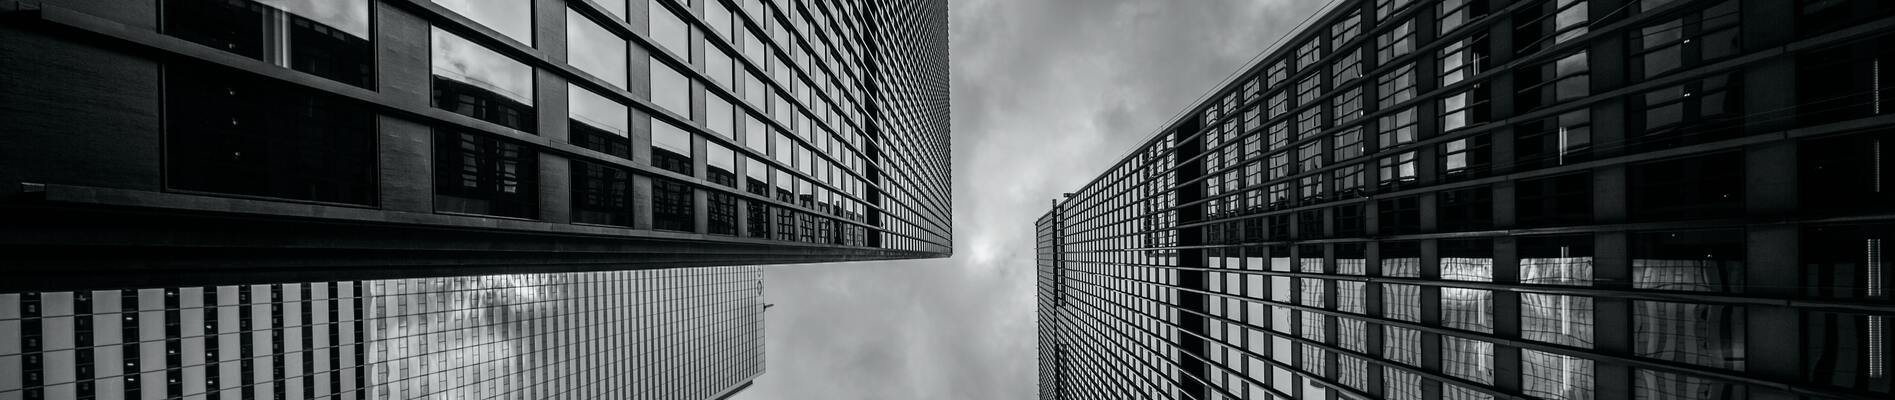

# **Indoor Location Navigation EDA**

In this competition (hosted by [Microsoft Research](https://www.microsoft.com/en-us/research/)), we aim to predict the position of a smartphone in an indoor location based on smartphone-provided data like accelerometer, gyroscope, magnometer readings, as well as WiFi and Bluetooth scans. The data is taken from hundreds of buildings in China. More details on the data collection is provided [here](https://github.com/location-competition/indoor-location-competition-20) and [here](https://www.youtube.com/watch?v=xt3OzMC-XMU).


In this notebook, I will provide an in-depth exploration of the data available for this competition. Please upvote if you find this notebook useful!

# Table of Contents

* [Dataset organization](#1) - Here, I briefly go over how the training and test dataset is organized.
* [Metadata organization](#2) - Here, I briefly go over what extra information is provided in the metadata.
* [Path text files](#3) - Here, I briefly analyze the path text files, how to open them, what features are available, etc.
* [Submission CSV and evaluation](#4) - Here, I show what needs to be predicted and how the results are evaluated.

In [ ]:
import os
import glob
from PIL import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm.notebook import tqdm
from pathlib import Path
from dataclasses import dataclass

<a id="1"></a>
## Dataset organization

Let's see what folders we have:

In [ ]:
dataset_path = Path('../input/indoor-location-navigation')
os.listdir(dataset_path)

We are provided with our train and test data, as well as metadata with additional information about the buildings (including maps) where the data collection took place.

Note that the data is organized by the sites and floors. How many sites do we have in this dataset?


In [ ]:
train_sites = os.listdir(dataset_path/"train")
print(f'There are {len(train_sites)} sites in the training set')

Each site folder is organized by the floor (a variable to predict!):

In [ ]:
example_site = os.listdir(dataset_path/"train")[10]
example_site_path = dataset_path/"train"/example_site
print('Floors for example site:')
print(os.listdir(example_site_path))

In [ ]:
floors_per_site = []
for i in os.listdir(dataset_path/"train"): floors_per_site.append(len(os.listdir(dataset_path/"train"/i)))
print(f'There are a total of {sum(floors_per_site)} floors. On average, each site has {np.mean(floors_per_site)} floors')

So every site has about 5 floors.

In each floor are the path trace text files with the data:

In [ ]:
print('Path text files for example floor:')
print(os.listdir(example_site_path/'B1'))

How many total training path files are there?

In [ ]:
print(f"There are {len(list((dataset_path/'train').rglob('*.txt')))} path text files in the training set")

To summarize, this is how the training data is structured:

```
└───train                                                        //raw data from two sites
      └───site1
      |     └───B1                                               //traces from one floor
      |     |   └───5dda14a2c5b77e0006b17533.txt                 //trace file                             
      |     |   | ...
      |     |
      |     |
      |     └───F1
      |     | ...
      |
      └───site2
```

Let's now move on to the test set. The test set simply is a collection of path text files:

In [ ]:
print(f"There are {len(os.listdir(dataset_path/'test'))} path text files in the test set")

<a id="2"></a>
## Metadata organization

Now let's check the metadata. It's organized in the same way the training set is organized. 

In [ ]:
print(f'There are {len(os.listdir(dataset_path/"metadata"))} sites in the metadata, just like the training set')

Let's look at a single floor of a single site:

In [ ]:
metadata_example_site = os.listdir(dataset_path/"metadata")[10]
metadata_example_site_path = dataset_path/"metadata"/metadata_example_site
metadata_example_floor_path = dataset_path/"metadata"/metadata_example_site/os.listdir(metadata_example_site_path)[0]
print(os.listdir(metadata_example_floor_path))

Each floor has metadata with a floor map, floor information, and geographic information.

In [ ]:
Image.open(metadata_example_floor_path/'floor_image.png')

In [ ]:
with open(metadata_example_floor_path/'geojson_map.json') as geojson_map:
    data = json.load(geojson_map)
    geojson_map.close()
print(data)

In [ ]:
with open(metadata_example_floor_path/'floor_info.json') as floor_info:
    data = json.load(floor_info)
    floor_info.close()
print(data)

<a id="3"></a>
## Path text files

Let's look more closely at the path text files and how to process them.

The [GitHub README](https://github.com/location-competition/indoor-location-competition-20) provides more information about the text file format:

> The first column is Unix Time in millisecond. In specific, we use SensorEvent.timestamp for sensor data and system time for WiFi and Bluetooth scans.
> 
>The second column is the data type (ten in total).
>
>TYPE_ACCELEROMETER
>
>TYPE_MAGNETIC_FIELD
>
>TYPE_GYROSCOPE
>
>TYPE_ROTATION_VECTOR
>
>TYPE_MAGNETIC_FIELD_UNCALIBRATED
>TYPE_GYROSCOPE_UNCALIBRATED
>
>TYPE_ACCELEROMETER_UNCALIBRATED
>
>TYPE_WIFI
>
>TYPE_BEACON
>
>TYPE_WAYPOINT: ground truth location labeled by the surveyor
>
>Data values start from the third column.
>
>Column 3-5 of TYPE_ACCELEROMETER、TYPE_ACCELEROMETER、TYPE_GYROSCOPE、TYPE_ROTATION_VECTOR are SensorEvent.values[0-2] from the callback function onSensorChanged(). Column 6 is SensorEvent.accuracy.
>
>Column 3-8 of TYPE_ACCELEROMETER_UNCALIBRATED、TYPE_GYROSCOPE_UNCALIBRATED、TYPE_MAGNETIC_FIELD_UNCALIBRATED are SensorEvent.values[0-5] from the callback function onSensorChanged(). Column 9 is SensorEvent.accuracy.

In [ ]:
example_floor_path = example_site_path/'B1'
example_txt_path = example_floor_path/os.listdir(example_floor_path)[0]

In [ ]:
with open(example_txt_path) as example_txt:
    data = example_txt.read()
    example_txt.close()

Here is an example text file (unhide the output, it's very long):

In [ ]:
print(data)

The organizers have thankfully provided some code for processing the text files over [here](https://github.com/location-competition/indoor-location-competition-20/blob/master/io_f.py). We will use that code to process our data (code is hidden):

In [ ]:
@dataclass
class ReadData:
    acce: np.ndarray
    acce_uncali: np.ndarray
    gyro: np.ndarray
    gyro_uncali: np.ndarray
    magn: np.ndarray
    magn_uncali: np.ndarray
    ahrs: np.ndarray
    wifi: np.ndarray
    ibeacon: np.ndarray
    waypoint: np.ndarray


def read_data_file(data_filename):
    acce = []
    acce_uncali = []
    gyro = []
    gyro_uncali = []
    magn = []
    magn_uncali = []
    ahrs = []
    wifi = []
    ibeacon = []
    waypoint = []

    with open(data_filename, 'r', encoding='utf-8') as file:
        lines = file.readlines()

    for line_data in lines:
        line_data = line_data.strip()
        if not line_data or line_data[0] == '#':
            continue

        line_data = line_data.split('\t')

        if line_data[1] == 'TYPE_ACCELEROMETER':
            acce.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ACCELEROMETER_UNCALIBRATED':
            acce_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE':
            gyro.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_GYROSCOPE_UNCALIBRATED':
            gyro_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD':
            magn.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_MAGNETIC_FIELD_UNCALIBRATED':
            magn_uncali.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_ROTATION_VECTOR':
            ahrs.append([int(line_data[0]), float(line_data[2]), float(line_data[3]), float(line_data[4])])
            continue

        if line_data[1] == 'TYPE_WIFI':
            sys_ts = line_data[0]
            ssid = line_data[2]
            bssid = line_data[3]
            rssi = line_data[4]
            lastseen_ts = line_data[6]
            wifi_data = [sys_ts, ssid, bssid, rssi, lastseen_ts]
            wifi.append(wifi_data)
            continue

        if line_data[1] == 'TYPE_BEACON':
            ts = line_data[0]
            uuid = line_data[2]
            major = line_data[3]
            minor = line_data[4]
            rssi = line_data[6]
            ibeacon_data = [ts, '_'.join([uuid, major, minor]), rssi]
            ibeacon.append(ibeacon_data)
            continue

        if line_data[1] == 'TYPE_WAYPOINT':
            waypoint.append([int(line_data[0]), float(line_data[2]), float(line_data[3])])

    acce = np.array(acce)
    acce_uncali = np.array(acce_uncali)
    gyro = np.array(gyro)
    gyro_uncali = np.array(gyro_uncali)
    magn = np.array(magn)
    magn_uncali = np.array(magn_uncali)
    ahrs = np.array(ahrs)
    wifi = np.array(wifi)
    ibeacon = np.array(ibeacon)
    waypoint = np.array(waypoint)

    return ReadData(acce, acce_uncali, gyro, gyro_uncali, magn, magn_uncali, ahrs, wifi, ibeacon, waypoint)

In [ ]:
example_data = read_data_file(example_txt_path)

Let's see the shape of the data:

In [ ]:
print(example_data.acce.shape)
print(example_data.acce_uncali.shape)
print(example_data.gyro.shape)
print(example_data.gyro_uncali.shape)
print(example_data.magn.shape)
print(example_data.magn_uncali.shape)
print(example_data.ahrs.shape)
print(example_data.wifi.shape)
print(example_data.ibeacon.shape)
print(example_data.waypoint.shape)

Here we have 9 features and the target:

`acce` - accelerometer data 

`acce_uncali` - uncalibrated accelerometer data

`gyro` - gyroscope data

`gyro_uncali` - uncalibrated gyroscope data

`magn` - magnetometer data

`magn_uncali` - uncalibrated magnetometer data

`ahrs` - rotation vector data

`wifi` - WiFi data

`ibeacon` - iBeacon data (sometimes can be missing)

`waypoint` - position, target


Let's look at the distribution of the number of datapoint for the features in the training data (code is hidden):

In [ ]:
acce_shape = []
acce_uncali_shape = []
gyro_shape = []
gyro_uncali_shape = []
magn_shape = []
magn_uncali_shape = []
ahrs_shape = []
wifi_shape = []
ibeacon_shape = []
train_files = list((dataset_path/'train').rglob('*.txt'))[:1000] #take a subset for now
for i in tqdm(train_files):
    train_data = read_data_file(i)
    acce_shape.append(train_data.acce.shape)
    acce_uncali_shape.append(train_data.acce_uncali.shape)
    gyro_shape.append(train_data.gyro.shape)
    gyro_uncali_shape.append(train_data.gyro_uncali.shape)
    magn_shape.append(train_data.magn.shape)
    magn_uncali_shape.append(train_data.magn_uncali.shape)
    ahrs_shape.append(train_data.ahrs.shape)
    wifi_shape.append(train_data.wifi.shape)
    ibeacon_shape.append(train_data.ibeacon.shape)


In [ ]:
_ = plt.hist([i[0] for i in acce_shape])
_ = plt.title('accelerometer # data points training set histogram')

In [ ]:
_ = plt.hist([i[0] for i in ahrs_shape])
_ = plt.title('rotation vector # data points training set histogram')

In [ ]:
_ = plt.hist([i[0] for i in wifi_shape])
_ = plt.title('WiFi # data points training set histogram')

In [ ]:
_ = plt.hist([i[0] for i in ibeacon_shape])
_ = plt.title('iBeacon # data points training set histogram')

Also, let's look for missing iBeacon data:

In [ ]:
print(f'{sum([i == (0,) for i in ibeacon_shape])} of the training samples are missing iBeacon data')

We can see that the shape of the arrays for the accelerometer, gyroscope, and magnetometer measuements are the same, likely because they are coming from the smartphone and sampled simultaneously. Interestingly, this sample is missing iBeacon data, so it looks like sometimes the iBeacon data is not present.

This function also works with the test files. The test files provide all the same information, except the waypoint, which is the target.

In [ ]:
example_test_data = read_data_file(dataset_path/'test'/os.listdir(dataset_path/'test')[0])

In [ ]:
print(example_test_data.acce.shape)
print(example_test_data.acce_uncali.shape)
print(example_test_data.gyro.shape)
print(example_test_data.gyro_uncali.shape)
print(example_test_data.magn.shape)
print(example_test_data.magn_uncali.shape)
print(example_test_data.ahrs.shape)
print(example_test_data.wifi.shape)
print(example_test_data.ibeacon.shape)
print(example_test_data.waypoint.shape) # will be zero because this is target

Like we did for the training data, let's look at the shape of the test data (code is hidden):

In [ ]:
acce_shape = []
acce_uncali_shape = []
gyro_shape = []
gyro_uncali_shape = []
magn_shape = []
magn_uncali_shape = []
ahrs_shape = []
wifi_shape = []
ibeacon_shape = []
test_files = os.listdir(dataset_path/'test')
for i in tqdm(range(len(test_files))):
    test_data = read_data_file(dataset_path/'test'/test_files[i])
    acce_shape.append(test_data.acce.shape)
    acce_uncali_shape.append(test_data.acce_uncali.shape)
    gyro_shape.append(test_data.gyro.shape)
    gyro_uncali_shape.append(test_data.gyro_uncali.shape)
    magn_shape.append(test_data.magn.shape)
    magn_uncali_shape.append(test_data.magn_uncali.shape)
    ahrs_shape.append(test_data.ahrs.shape)
    wifi_shape.append(test_data.wifi.shape)
    ibeacon_shape.append(test_data.ibeacon.shape)


In [ ]:
_ = plt.hist([i[0] for i in acce_shape])
_ = plt.title('accelerometer # data points test set histogram')

In [ ]:
_ = plt.hist([i[0] for i in ahrs_shape])
_ = plt.title('rotation vector # data points test set histogram')

In [ ]:
_ = plt.hist([i[0] for i in wifi_shape])
_ = plt.title('WiFi # data points test set histogram')

In [ ]:
_ = plt.hist([i[0] for i in ibeacon_shape])
_ = plt.title('iBeacon # data points test set histogram')

Also, let's look for missing iBeacon data:

In [ ]:
print(f'{sum([i == (0,) for i in ibeacon_shape])} of the test samples are missing iBeacon data')

<a id="4"></a>
## Submission CSV and evaluation

Lastly, let's look at the submission CSV and figure out what we need to predict and how our results are evaluated.

In [ ]:
sample_df = pd.read_csv(dataset_path/'sample_submission.csv')

In [ ]:
sample_df.head(10)

We see that we are given the name of the path trace files and we are supposed to predict the floor number, as well as the position (x,y). The name of the path trace file provides the ID for the site as well as the path ID and UNIX timestamp. We can see that the sites in the test site are also present in the training set.

In [ ]:
unique_test_sites = list(set([j[0] for j in [i.split('_') for i in list(sample_df.site_path_timestamp)]]))
len(list(set(unique_test_sites) & set(train_sites))) == len(unique_test_sites)

Let's look at how our submission is evaluated:

> 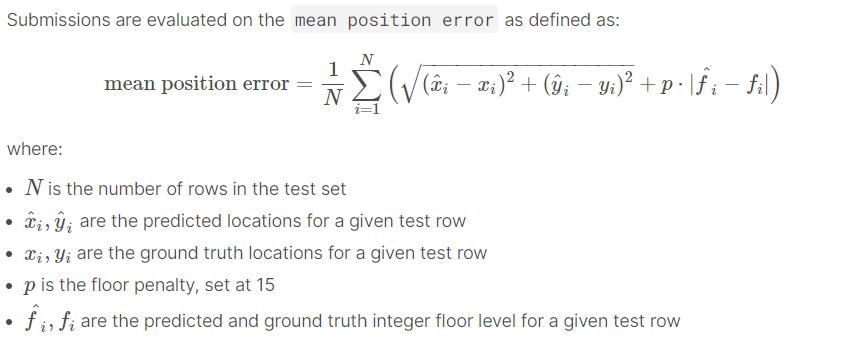

Note that the floor numbers are mapped to integers for the submission file. The above-ground floors are mapped as the floor number minue one. For example F1 would be mapped to 0, F2 to 1, F3 to 2, etc. The below-ground floors are mapped to negative floor numbers. For example B1 is -1, B2 is -2, B3 is -3, etc. There are non-traditional floor numbers in the training set (ex: LG2, LM, etc.) but those are not in the test set.

In [ ]:
sample_df.to_csv('submission.csv',index=False)

**THE END**

Please upvote if you found this notebook useful!